In [1]:
# imports
import os, sys
import tensorflow as tf
from tqdm import tqdm_notebook as tqdm
import numpy as np
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'tqdm'

In [ ]:
if not os.path.exists('tiny_nerf_data.npz'):
    !wget http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz

name = "nerf_model_pos_only.h5"

# from google.colab import drive
# drive.mount('/content/gdrive')

--2022-05-28 20:16:14--  http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz
Resolving cseweb.ucsd.edu (cseweb.ucsd.edu)... 132.239.8.30
Connecting to cseweb.ucsd.edu (cseweb.ucsd.edu)|132.239.8.30|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cseweb.ucsd.edu//~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz [following]
--2022-05-28 20:16:14--  https://cseweb.ucsd.edu//~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz
Connecting to cseweb.ucsd.edu (cseweb.ucsd.edu)|132.239.8.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12727482 (12M)
Saving to: ‘tiny_nerf_data.npz’

tiny_nerf_data.npz  100%[===================>]  12.14M  16.1MB/s    in 0.8s    

2022-05-28 20:16:15 (16.1 MB/s) - ‘tiny_nerf_data.npz’ saved [12727482/12727482]

Mounted at /content/gdrive


In [ ]:
def save_model(model):
    model.save(name)
    print("model saved to current machine")
    model.save(os.path.join("gdrive/MyDrive", name))
    print("model saved to drive.")

tf.Tensor(0.0072000003, shape=(), dtype=float32)
image size is: (100, 100, 3)


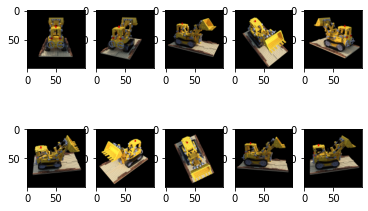

In [ ]:
data = np.load('Data/tiny_nerf_data.npz')
images = data['images']
poses = data['poses']
focal = data['focal']
focal = tf.convert_to_tensor(1. / focal, dtype=tf.float32)
print(focal)
print(f"image size is: {images[0].shape}")
H, W, _ = images[0].shape
# plt.figure(figsize=(10, 10))
n = 10
for i in range(n):
    plt.subplot(2, 5, i+1)
    plt.imshow(images[i])


In [ ]:
test_images, test_poses = images[100:], poses[100:]
train_images, train_poses = images[:100], poses[:100]

train_size, test_size = train_images.shape[0], test_images.shape[0]
print(f"training data size={train_size} and test data size={test_size}")

training data size=100 and test data size=6


In [ ]:
#input formatting
import sys

# positoin encoding in terms of frequency
@tf.function
def pos_enc(x, level=6):
    # res = [x]
    # for i in range(level):
    #     for fn in (tf.sin, tf.cos):
    #         res.append(fn((2. ** i) * x))
    # return tf.concat(res, -1)
    return tf.concat([x, 
                      tf.sin((2**0)*x), tf.cos((2**0)*x),
                      tf.sin((2**1)*x), tf.cos((2**1)*x),
                      tf.sin((2**2)*x), tf.cos((2**2)*x),
                      tf.sin((2**3)*x), tf.cos((2**3)*x),
                      tf.sin((2**4)*x), tf.cos((2**4)*x),
                      tf.sin((2**5)*x), tf.cos((2**5)*x)
                      ], -1)


@tf.function
def get_angles(ray_d):
    theta = tf.reduce_sum(ray_d[..., None, :] * tf.constant([0., 0., 1.]), -1) / tf.sqrt(tf.reduce_sum(tf.square(ray_d), -1))[..., None]
    phi   = tf.reduce_sum(ray_d[..., None, :] * tf.constant([1., 0., 0.]), -1) / tf.sqrt(tf.reduce_sum(tf.square(ray_d), -1))[..., None]
    return tf.math.acos(theta), tf.math.acos(phi)


def init_model(size=8, depth=256, level=6):
    inputsize = 0 + 3 + 3*(2*level)
    input = tf.keras.layers.Input(inputsize)

    output = input
    for i in range(size):
        output = tf.keras.layers.Dense(depth, activation='relu')(output)
    output = tf.keras.layers.Dense(4, activation=None)(output)

    model = tf.keras.Model(inputs=input, outputs=output)
    # print(model.summary())
    return model

@tf.function
def get_rays(H, W, focal, c2w):
    c2w = tf.convert_to_tensor(c2w, dtype=tf.float32)
    i, j = tf.meshgrid(tf.range(W, dtype=tf.float32), tf.range(H, dtype=tf.float32), indexing='xy')
    dirs = tf.stack([(i-W*.5) * focal, -(j-H*.5) * focal, -tf.ones_like(i)], -1) # NOTE: multiplied by focal, because focal inverted already
    rays_d = tf.reduce_sum(dirs[..., np.newaxis, :] * c2w[:3,:3], -1)
    rays_o = tf.broadcast_to(c2w[:3,-1], tf.shape(rays_d))
    return rays_o, rays_d

# pose = train_poses[0]
# ray_o, ray_d = get_rays(H, W, focal, pose)
# # ray_d = tf.convert_to_tensor(np.array([1., 0., 0.]).reshape(1, 1, 3), dtype=tf.float32)
# print(ray_d[0, 0, :])
# print(np.linalg.norm(ray_d[0, 0, :]))
# t, p = get_angles(ray_d)
# print("="*10)
# print(t)
# print(p)

In [ ]:
#render rays
@tf.function
def render(fn, ray_o, ray_d, near, far, samples):
    #sampling points
    line = tf.linspace(near, far, samples)
    points = ray_o[..., None, :] + line[..., :, None] * ray_d[..., None, :]
    #print(f"points shape: {points.shape}")
    points_flt = tf.reshape(points, (-1, 3))
    points_enc = pos_enc(points_flt)
    #print(f"points enc shape: {points_enc.shape}")
    
    # theta, phi = get_angles(ray_d)
    # theta = tf.reshape(tf.stack([theta]*samples, -2), (-1, 1))
    # phi   = tf.reshape(tf.stack([phi]*samples, -2), (-1, 1))
    
    # print(f"theta shape is : {theta.shape}")
    # print(f"phi shape is : {phi.shape}")

    # inp = tf.concat([points_enc, theta, phi], -1)
    inp = points_enc

    # print(f"inp shape is : {inp.shape}")
    out = model(inp)
    color, sigma = out[..., :3], out[..., 3:]
    color = tf.math.sigmoid(tf.reshape(color, (-1, samples, 3)))
    sigma = tf.nn.relu(tf.reshape(sigma, (-1, samples, 1)))
    # print(f"color shape is: {color.shape}")
    # print(f"sigma shape is: {sigma.shape}")
    # print(f"line shape is: {line.shape}")
    dist = tf.reshape(tf.concat([line[..., 1:] - line[..., :-1], tf.broadcast_to([1e10], line[..., :1].shape)], -1), [-1,1])
    # print(f"dist shape is: {dist.shape}")
    alpha = 1. - tf.exp(-sigma * dist)
    # print(f"alpha shape is: {alpha.shape}")
    weights = alpha * tf.math.cumprod(1. - alpha + 1e-12, -1, exclusive=True)
    rgb = tf.reduce_sum(weights * color, -2)
    # print(f"rgb shape is: {rgb.shape}")
    return rgb

if os.path.exists(name):
    model = tf.keras.models.load_model(name)
    print("model loaded from current machine")
elif os.path.exists(os.path.join("gdrive/MyDrive", name)):
    model = tf.keras.models.load_model(os.path.join("gdrive/MyDrive", name))
    print("model loaded from gdrive")
else:
    model = init_model()
    print("creating new model")

model = init_model()
pose = train_poses[0]
ray_o, ray_d = get_rays(H, W, focal, pose)
val = render(model, ray_o, ray_d, 2., 6., 4)

model loaded from current machine


model saved to current machine
model saved to drive.


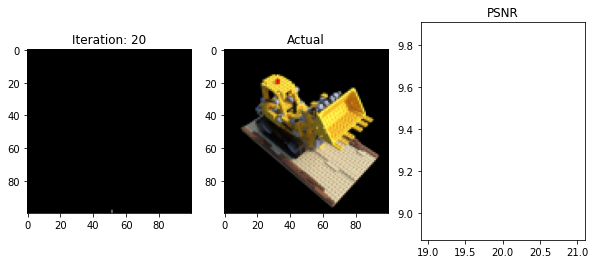

model saved to current machine
model saved to drive.


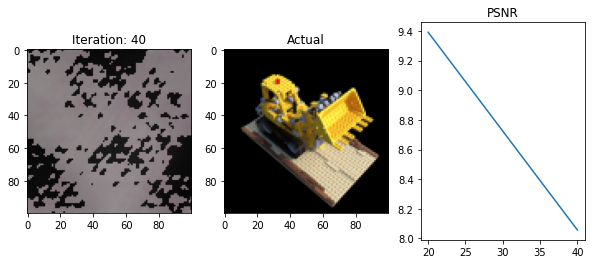

model saved to current machine
model saved to drive.


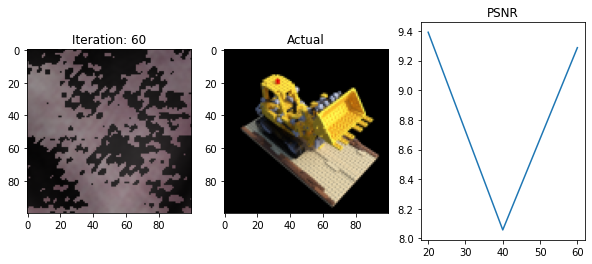

model saved to current machine
model saved to drive.


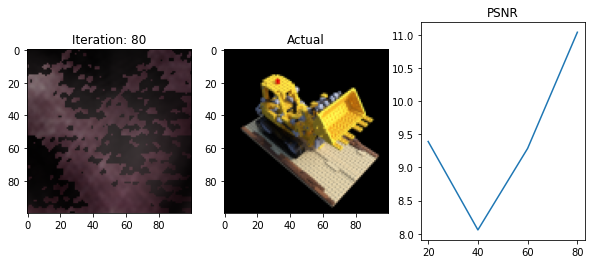

model saved to current machine
model saved to drive.


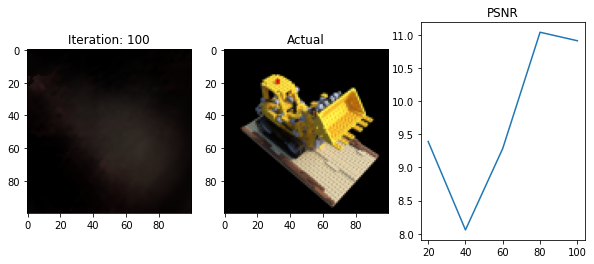

model saved to current machine
model saved to drive.


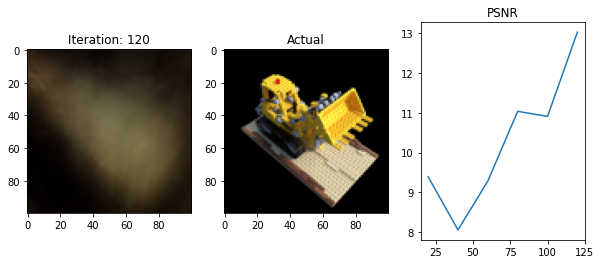

model saved to current machine
model saved to drive.


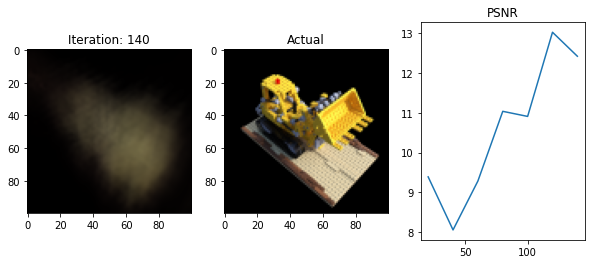

model saved to current machine
model saved to drive.


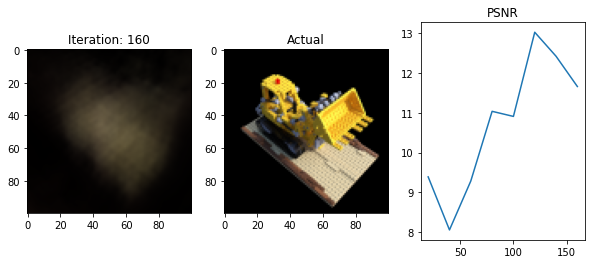

model saved to current machine
model saved to drive.


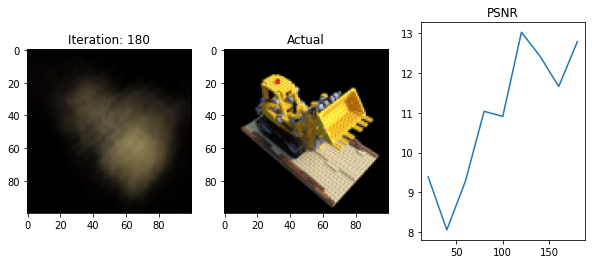

model saved to current machine
model saved to drive.


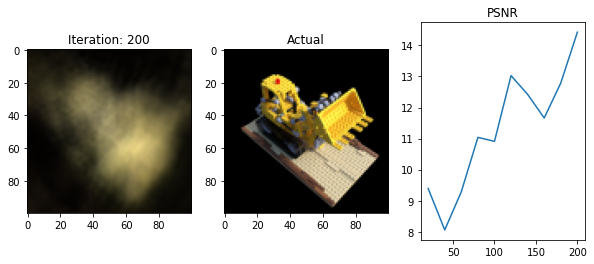

model saved to current machine
model saved to drive.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


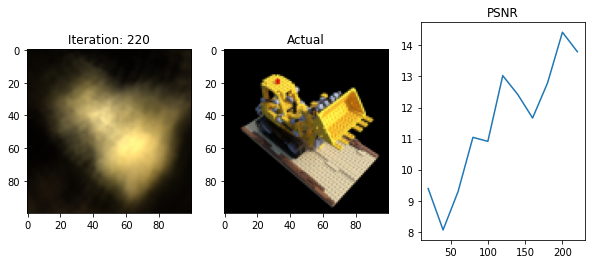

model saved to current machine
model saved to drive.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


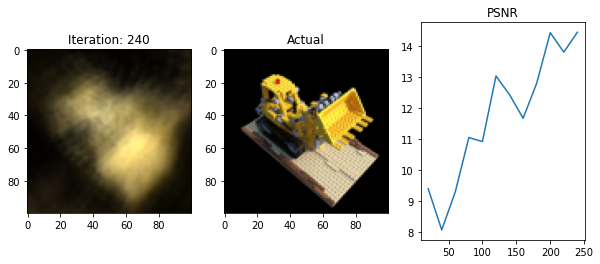

model saved to current machine
model saved to drive.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


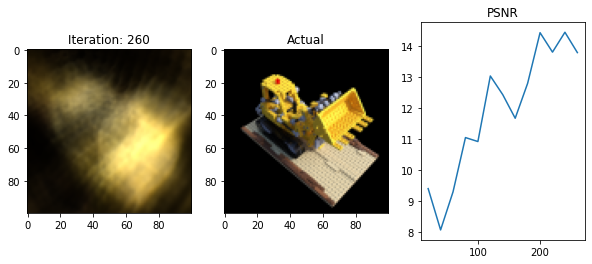

model saved to current machine
model saved to drive.


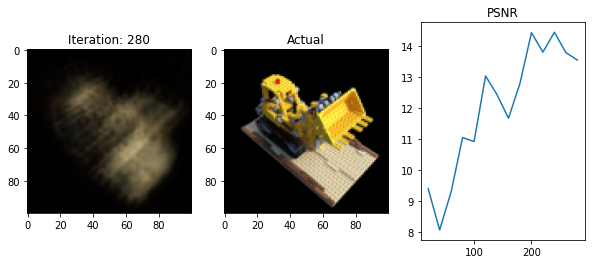

model saved to current machine
model saved to drive.


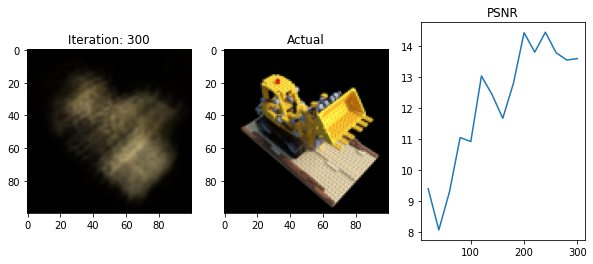

model saved to current machine
model saved to drive.


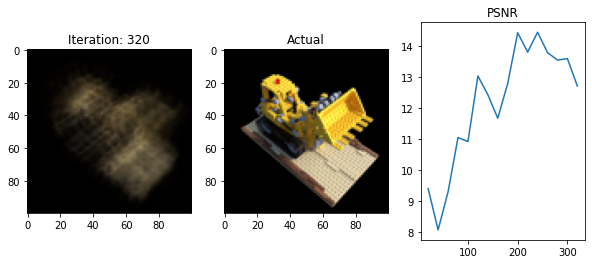

model saved to current machine
model saved to drive.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


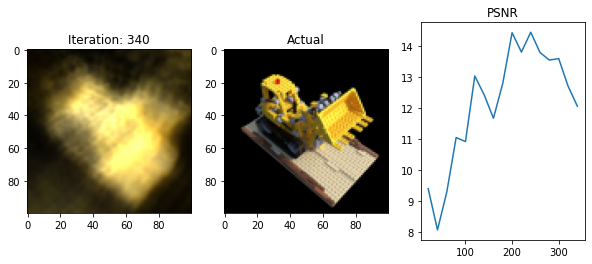

model saved to current machine
model saved to drive.


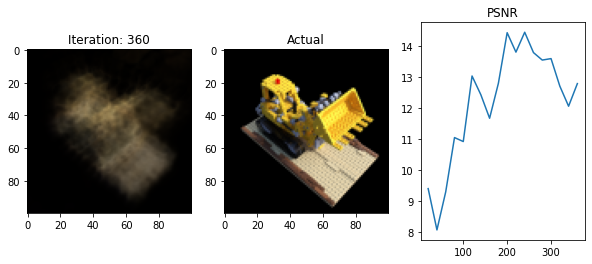

model saved to current machine
model saved to drive.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


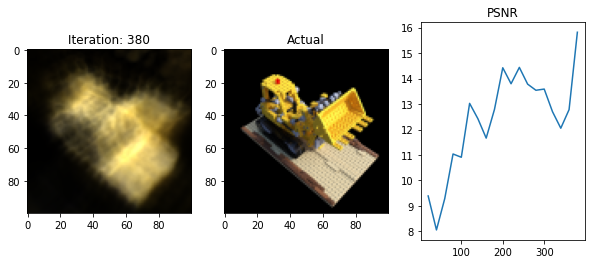

model saved to current machine
model saved to drive.


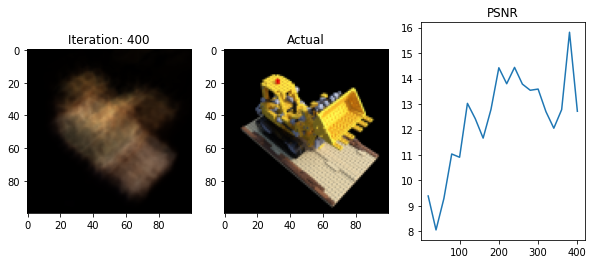

model saved to current machine
model saved to drive.


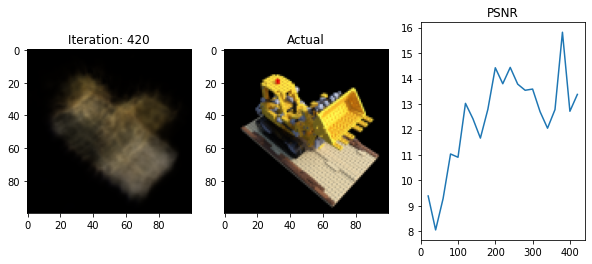

model saved to current machine
model saved to drive.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


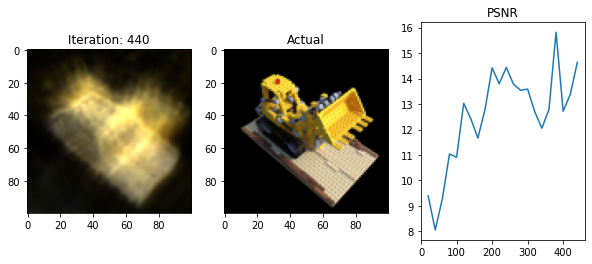

model saved to current machine
model saved to drive.


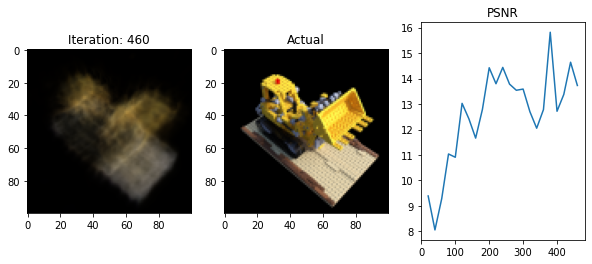

model saved to current machine
model saved to drive.


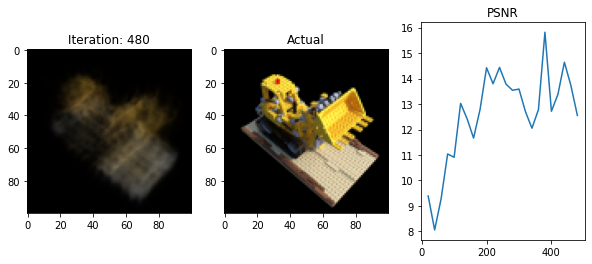

model saved to current machine
model saved to drive.


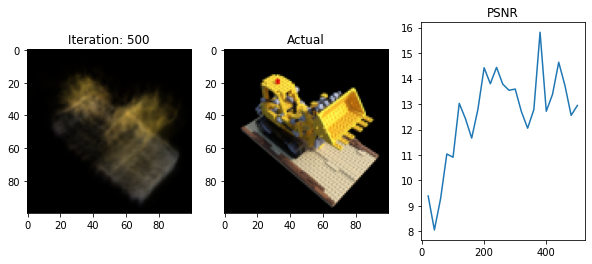

model saved to current machine
model saved to drive.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


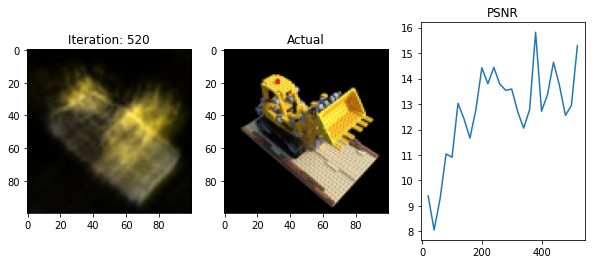

model saved to current machine
model saved to drive.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


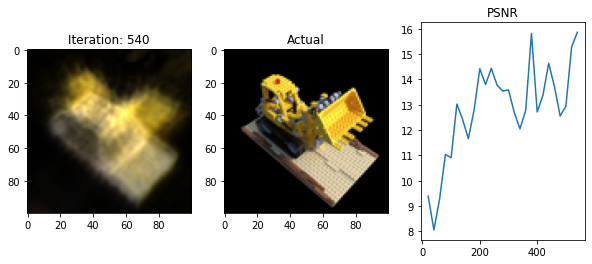

model saved to current machine
model saved to drive.


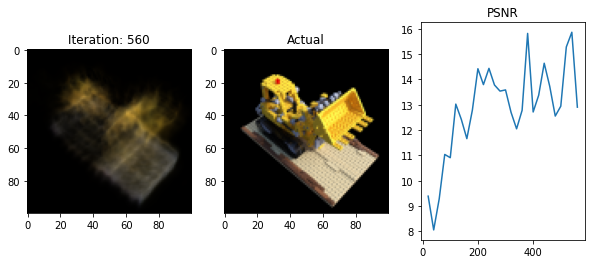

model saved to current machine
model saved to drive.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


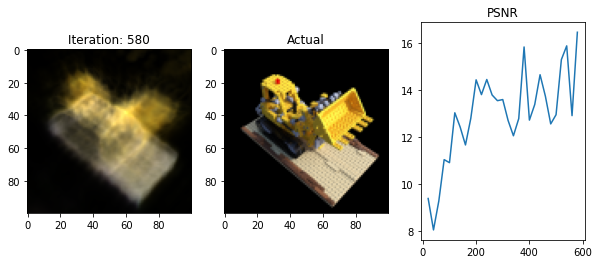

model saved to current machine
model saved to drive.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


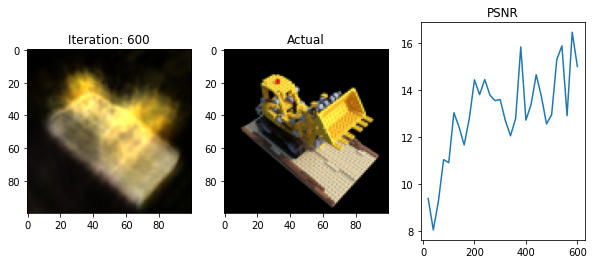

model saved to current machine
model saved to drive.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


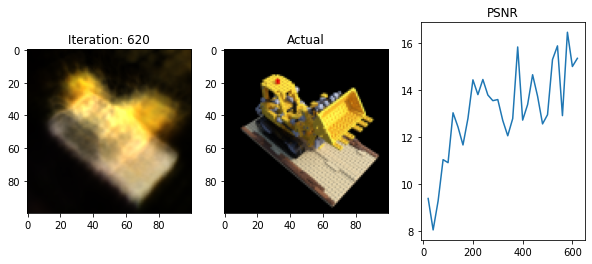

model saved to current machine
model saved to drive.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


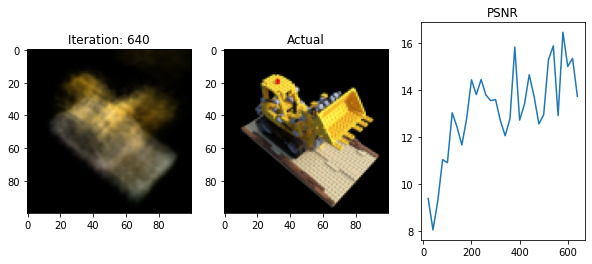

model saved to current machine
model saved to drive.


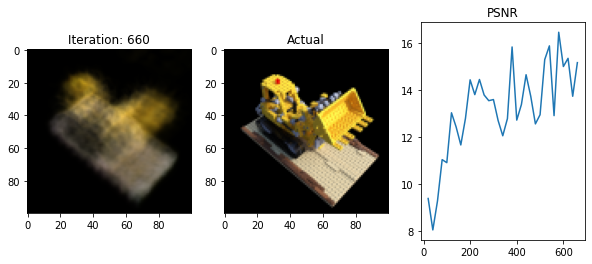

model saved to current machine
model saved to drive.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


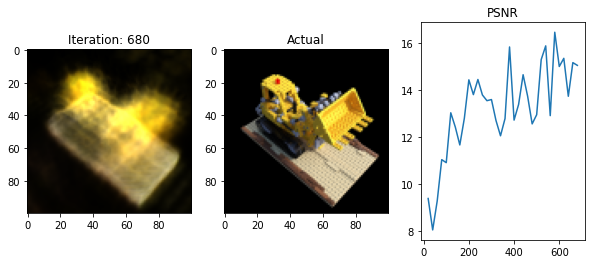

model saved to current machine
model saved to drive.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


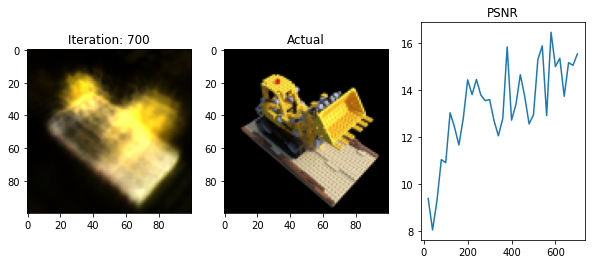

model saved to current machine
model saved to drive.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


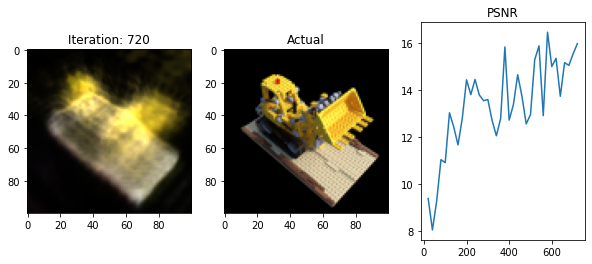

model saved to current machine
model saved to drive.


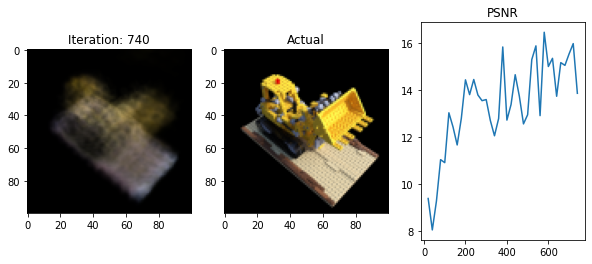

model saved to current machine
model saved to drive.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


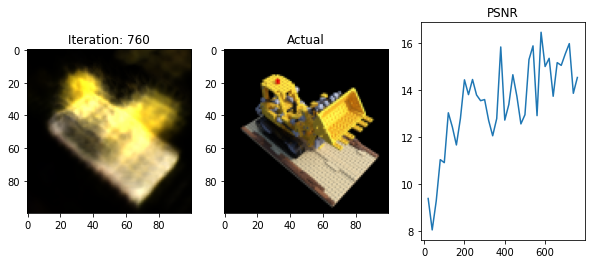

model saved to current machine
model saved to drive.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


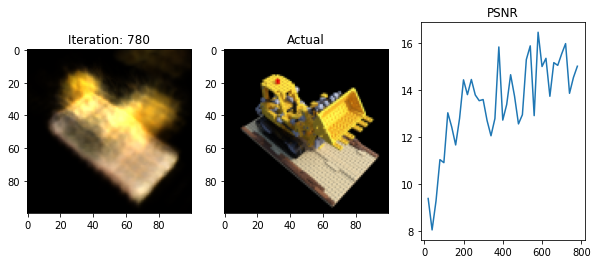

model saved to current machine
model saved to drive.


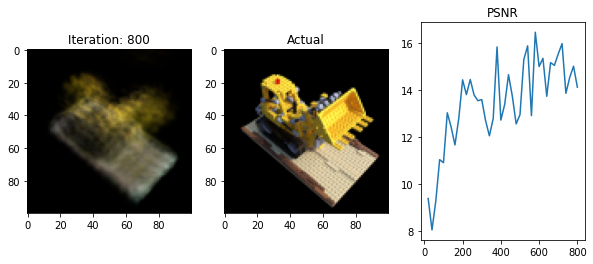

model saved to current machine
model saved to drive.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


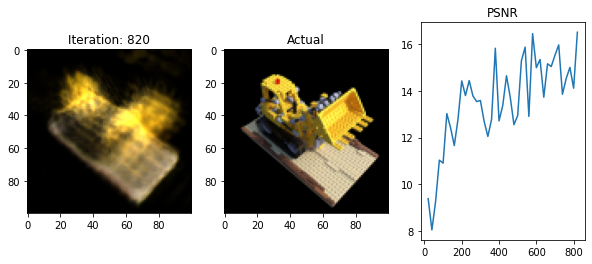

model saved to current machine
model saved to drive.


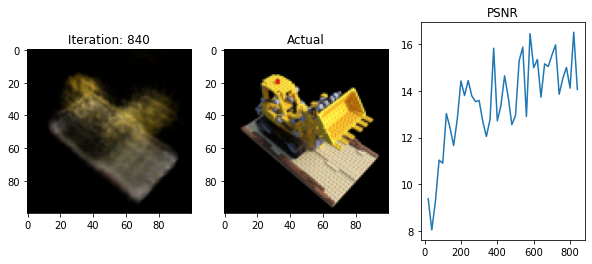

model saved to current machine
model saved to drive.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


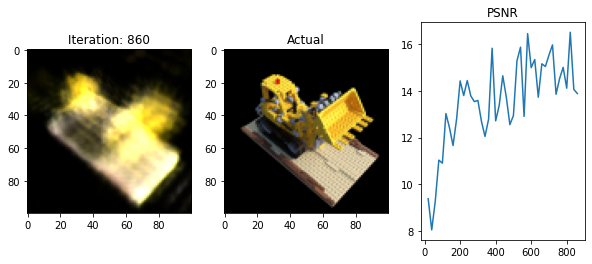

model saved to current machine
model saved to drive.


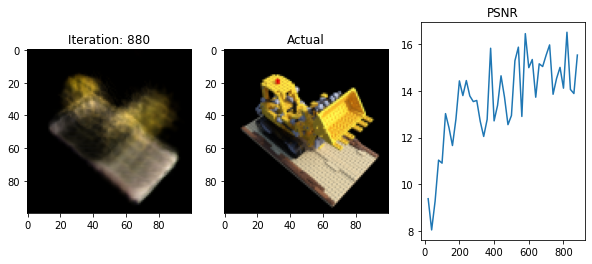

model saved to current machine
model saved to drive.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


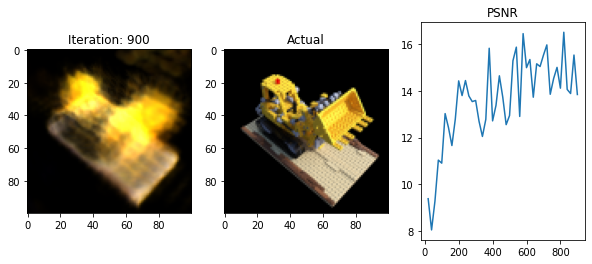

model saved to current machine
model saved to drive.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


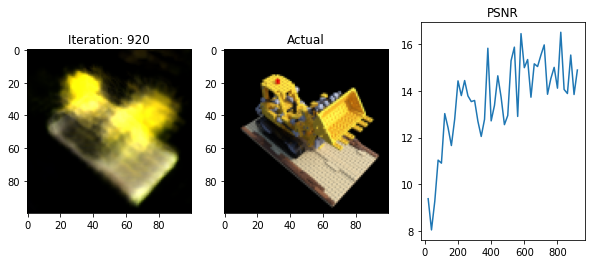

model saved to current machine
model saved to drive.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


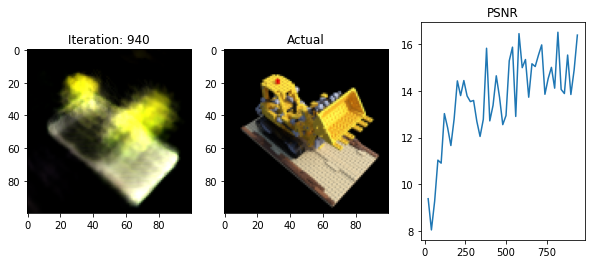

model saved to current machine
model saved to drive.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


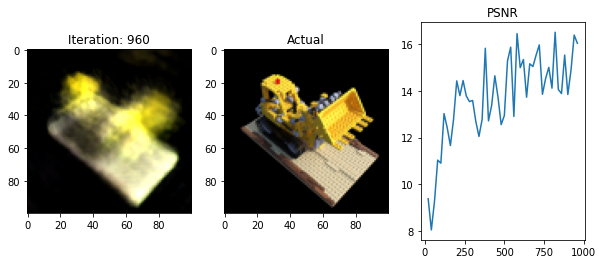

model saved to current machine
model saved to drive.


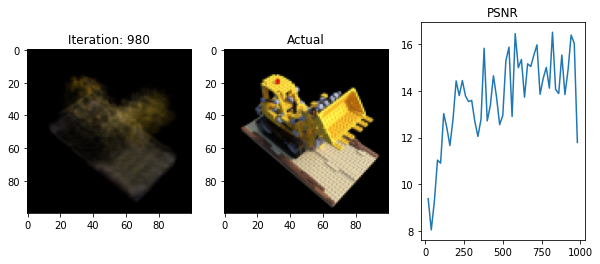

model saved to current machine
model saved to drive.


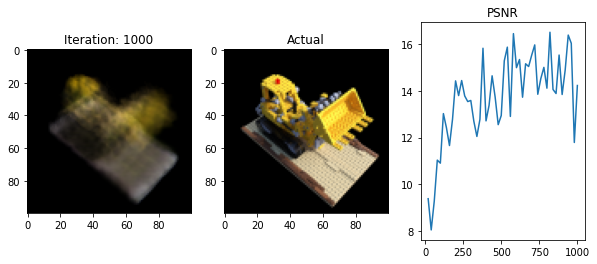

Done


In [ ]:
# training starts
epochs   = 1000
samples  = 64
rate     = 5e-4
psnrs    = []
iternums = []

var = model.trainable_variables
for epoch in range(epochs+1):
    index = np.random.randint(train_images.shape[0])

    image  = train_images[index]
    target = tf.reshape(image, [-1, 3])
    pose   = train_poses[index]

    ray_o, ray_d = get_rays(H, W, focal, pose)

    with tf.GradientTape() as tape:
        rgb  = render(model, ray_o, ray_d, 2., 6., samples)
        loss = tf.reduce_mean(tf.square(rgb - target))

    gradients = tape.gradient(loss, var)
    tf.keras.optimizers.Adam(rate).apply_gradients(zip(gradients, var))

    if (epoch%(epochs//50)) == 0 and epoch != 0:

        save_model(model)
        testpose = test_poses[1]
        testimg = test_images[1]
        target = tf.reshape(testimg, [-1, 3])

        ray_o, ray_d = get_rays(H, W, focal, testpose)
        rgb  = render(model, ray_o, ray_d, 2., 6., samples)
        losst = tf.reduce_mean(tf.square(rgb - target))

        psnr = -10. * tf.math.log(losst) / tf.math.log(10.)
        psnrs.append(psnr.numpy())
        iternums.append(epoch)

        plt.figure(figsize=[10, 4])
        
        plt.subplot(1, 3, 1)
        img = tf.reshape(rgb, [H, W, -1]).numpy()
        plt.imshow(img)
        plt.title(f"Iteration: {epoch}")

        plt.subplot(1, 3, 2)
        plt.imshow(testimg)
        plt.title("Actual")
        
        plt.subplot(1, 3, 3)
        plt.plot(iternums, psnrs)
        plt.title('PSNR')
        plt.show()

print('Done')


In [ ]:
save_model(model)

from google.colab import files
files.download(name)

model saved to current machine
model saved to drive.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!ls -l gdrive/MyDrive/

total 26871
-rw------- 1 root root   30311 May  2 14:12 'Acct Statement_XX2650_02052022.pdf'
drwx------ 2 root root    4096 Sep 16  2021 'Colab Notebooks'
-rw------- 1 root root     143 May 16 06:01 'Copy of Salary Breakup.gsheet'
-rw------- 1 root root   81504 Apr 21 12:01 'Danish Amin - Resume.pdf'
-rw------- 1 root root  475522 Jul 11  2021 'Editable Template_Jio Techsters Flagship Program 2021+.pptx'
-rw------- 1 root root 1560010 Mar  3  2017 'Getting started.pdf'
-rw------- 1 root root 1354014 May 17  2019  IMG_20170726_133827.jpg
-rw------- 1 root root 1459516 May 17  2019  IMG_20170726_133833.jpg
-rw------- 1 root root  185118 May 17  2019  IMG_20170726_162623.jpg
-rw------- 1 root root  337455 May 17  2019  IMG_20170726_162651.jpg
drwx------ 2 root root    4096 Mar  6  2021  important_Documents
-rw------- 1 root root  222950 May  2 09:44  itp.png
drwx------ 2 root root    4096 Dec 29  2019  laptopchangebackup
-rw------- 1 root root     143 May  2 14:26 'Masters University.gshe

In [ ]:
%matplotlib inline
from ipywidgets import interactive, widgets


trans_t = lambda t : tf.convert_to_tensor([
    [1,0,0,0],
    [0,1,0,0],
    [0,0,1,t],
    [0,0,0,1],
], dtype=tf.float32)

rot_phi = lambda phi : tf.convert_to_tensor([
    [1,0,0,0],
    [0,tf.cos(phi),-tf.sin(phi),0],
    [0,tf.sin(phi), tf.cos(phi),0],
    [0,0,0,1],
], dtype=tf.float32)

rot_theta = lambda th : tf.convert_to_tensor([
    [tf.cos(th),0,-tf.sin(th),0],
    [0,1,0,0],
    [tf.sin(th),0, tf.cos(th),0],
    [0,0,0,1],
], dtype=tf.float32)


def pose_spherical(theta, phi, radius):
    c2w = trans_t(radius)
    c2w = rot_phi(phi/180.*np.pi) @ c2w
    c2w = rot_theta(theta/180.*np.pi) @ c2w
    c2w = np.array([[-1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]]) @ c2w
    return c2w


def f(**kwargs):
    c2w = pose_spherical(**kwargs)
    rays_o, rays_d = get_rays(H, W, focal, c2w[:3,:4])
    rgb  = render(model, rays_o, rays_d, 2., 6., samples).numpy()
    rgb = rgb.reshape(H, W, 3)
    # rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples)
    img = np.clip(rgb,0,1)
    
    plt.figure(2, figsize=(20,6))
    plt.imshow(img)
    plt.show()
    

sldr = lambda v, mi, ma: widgets.FloatSlider(
    value=v,
    min=mi,
    max=ma,
    step=.01,
)

names = [
    ['theta', [100., 0., 360]],
    ['phi', [-30., -90, 0]],
    ['radius', [4., 3., 5.]],
]

interactive_plot = interactive(f, **{s[0] : sldr(*s[1]) for s in names})
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(FloatSlider(value=100.0, description='theta', max=360.0, step=0.01), FloatSlider(value=-…

In [ ]:
frames = []
for th in tqdm(np.linspace(0., 360., 120, endpoint=False)):
    c2w = pose_spherical(th, -30., 4.)
    rays_o, rays_d = get_rays(H, W, focal, c2w[:3,:4])
    rgb  = render(model, rays_o, rays_d, 2., 6., samples).numpy()
    rgb = rgb.reshape(H, W, 3)
    # rgb, depth, acc = render(model, rays_o, rays_d, 2., far=6., N_samples=samples)
    frames.append((255*np.clip(rgb,0,1)).astype(np.uint8))

import imageio
f = 'video.mp4'
imageio.mimwrite(f, frames, fps=30, quality=7)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/120 [00:00<?, ?it/s]

In [ ]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('video.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls autoplay loop>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras


# function
@tf.function
def f(x):
    return 5*tf.sin(3*x)
    # return x**3. - x**2. + x + 1.


#data
total_points = 1001
x = tf.linspace(-2., 2., total_points)
y = f(x)
y_ = y + 0.1*tf.random.normal([total_points])

plt.plot(x, y)
plt.scatter(x, y_, s=0.3, c='r')
plt.grid()
plt.axvline()
plt.axhline()
plt.show()

In [ ]:
input = keras.layers.Input(1)
output = input

for i in range(8):
    output = keras.layers.Dense(256, activation='relu')(output)
output = keras.layers.Dense(1, activation=None)(output)

model = keras.Model(inputs=input, outputs=output)
model.summary()

In [ ]:
#training
import matplotlib
matplotlib.rcParams['figure.figsize'] = [6, 4]
variables = model.trainable_variables

n = 1000
# for epoch in range(n):

#     with tf.GradientTape() as tape:
#         loss = keras.losses.MSE(y[:, None], model(x[:, None]))
#     gradients = tape.gradient(loss,variables)
#     keras.optimizers.Adam(3e-4).apply_gradients(zip(gradients,variables))

#     if epoch%(n//10) == 0:
#             print(f"epoch is {epoch} and loss is: {tf.reduce_mean(loss)}")
#             pred = model(x)
#             plt.plot(x, pred, label='prediction')
#             plt.plot(x, y, label='ground truth')
#             plt.scatter(x, y_, s=0.3, c='g', label='data')
#             plt.legend()
#             plt.show()

model.compile(loss=keras.losses.MSE, optimizer=keras.optimizers.Adam(3e-4))
history = model.fit(x, y_, epochs=n)
plt.plot(history.history['loss'])
plt.show()

In [ ]:
pred = model(x)
plt.plot(x, pred, label='prediction')
plt.plot(x, y, label='ground truth')
plt.scatter(x, y_, s=0.2, c='g', label='data')
plt.legend()
plt.show()